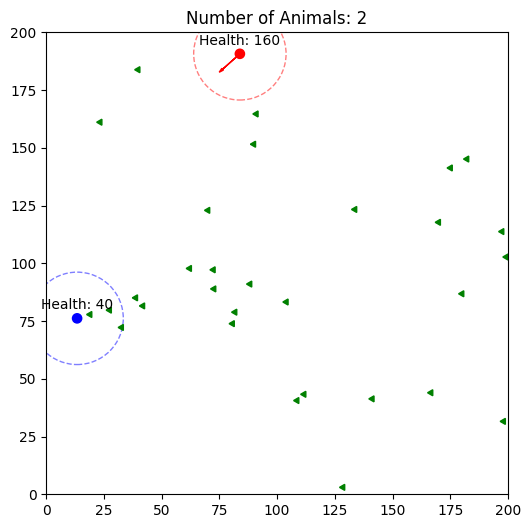

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from IPython.display import clear_output
import time

# Field dimensions
FIELD_SIZE = 200

# Utility function to calculate distance between two positions
def distance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

class Animal:
    def __init__(self, position, size=2, speed=1, health=100, radius_of_view=20, direction_change_interval=10, color='blue'):
        self.position = np.array(position, dtype='float')
        self.size = size
        self.speed = speed
        self.health = health
        self.radius_of_view = radius_of_view
        self.direction_change_interval = direction_change_interval
        self.steps_in_current_direction = 0
        self.current_direction = None  # Will be set when needed
        self.color = color

    def move(self, food_items):
        """Move the animal towards the closest food within its radius of view, or move randomly if no food is nearby."""
        closest_food = self.get_closest_food(food_items)

        if closest_food:
            self.move_towards(closest_food.position)
        else:
            self.random_move()

        # Keep within field bounds
        self.position = np.clip(self.position, 0, FIELD_SIZE)
        self.health -= 0.5  # Health decreases over time

    def move_towards(self, target_position):
        """Move the animal towards a specific position."""
        direction = target_position - self.position
        direction /= np.linalg.norm(direction)  # Normalize direction vector
        self.position += direction * self.speed
        self.steps_in_current_direction = 0
        self.current_direction = None

    def random_move(self):
        """Move in a random direction for a set number of steps."""
        if self.steps_in_current_direction == 0 or self.current_direction is None:
            angle = np.random.uniform(0, 2 * np.pi)
            self.current_direction = np.array([np.cos(angle), np.sin(angle)])
            self.steps_in_current_direction = self.direction_change_interval

        self.position += self.current_direction * self.speed
        self.steps_in_current_direction -= 1

    def get_closest_food(self, food_items):
        """Find the closest food within the animal's radius of view."""
        if not food_items:
            return None

        food_positions = np.array([food.position for food in food_items])
        distances = np.linalg.norm(food_positions - self.position, axis=1)
        within_view = distances <= self.radius_of_view

        if np.any(within_view):
            closest_food_idx = np.argmin(distances[within_view])
            return food_items[np.where(within_view)[0][closest_food_idx]]

        return None

    def consume_food(self, food):
        """Increase health when the animal consumes food."""
        self.health += 20

    def is_alive(self):
        """Check if the animal is still alive (has health greater than 0)."""
        return self.health > 0

class Food:
    def __init__(self, position):
        self.position = np.array(position)

def simulate(animals, food_items, steps=100):
    """Simulate the behavior of animals and food over a number of steps."""
    for step in range(steps):
        animals = [animal for animal in animals if animal.is_alive()]
        if not animals:
            print("All animals have run out of health.")
            break

        for animal in animals:
            animal.move(food_items)

            # Check for food consumption during the move
            food_items = handle_food_consumption(animal, food_items)

        visualize(animals, food_items)
        time.sleep(0.1)  # Pause for visualization
        clear_output(wait=True)

def handle_food_consumption(animal, food_items):
    """Handle food consumption for an individual animal."""
    remaining_food = food_items.copy()

    for food in remaining_food[:]:
        if distance(animal.position, food.position) < animal.size:
            animal.consume_food(food)
            remaining_food.remove(food)
            # print(f"Animal at {animal.position} consumed food at {food.position}. Health: {animal.health}")

    return remaining_food

def visualize(animals, food_items):
    """Visualize the animals and food on the field."""
    fig, ax = plt.subplots(figsize=(6,6))

    # Draw the animals
    for animal in animals:
        circle = Circle(animal.position, animal.size, color=animal.color)
        ax.add_patch(circle)

        # Draw the radius of view
        view_circle = Circle(animal.position, animal.radius_of_view, color=animal.color, fill=False, linestyle='--', alpha=0.5)
        ax.add_patch(view_circle)

        # Draw the movement direction (if moving randomly)
        if animal.current_direction is not None and animal.steps_in_current_direction > 0:
            arrow_scale = animal.size * 5
            ax.arrow(animal.position[0], animal.position[1],
                     animal.current_direction[0] * arrow_scale,
                     animal.current_direction[1] * arrow_scale,
                     head_width=1, head_length=2, fc=animal.color, ec=animal.color)

        # Display health value near the animal
        ax.text(animal.position[0], animal.position[1] + animal.size + 2, f"Health: {int(animal.health)}", 
                color='black', fontsize=10, ha='center')

    # Draw the food items
    for food in food_items:
        triangle = RegularPolygon(food.position, numVertices=3, radius=1.5, orientation=np.pi / 2, color='green')
        ax.add_patch(triangle)

    # Set field limits and aspect ratio
    ax.set_xlim(0, FIELD_SIZE)
    ax.set_ylim(0, FIELD_SIZE)
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Number of Animals: {len(animals)}")
    plt.show()

# Initialize animals and food
animal1 = Animal(position=[FIELD_SIZE / 4, FIELD_SIZE / 4], size=2, speed=2, health=100, radius_of_view=20, direction_change_interval=10, color='blue')
animal2 = Animal(position=[3 * FIELD_SIZE / 4, 3 * FIELD_SIZE / 4], size=2, speed=2, health=100, radius_of_view=20, direction_change_interval=10, color='red')
animals = [animal1, animal2]

num_food_items = 40
food_items = [Food(position=np.random.uniform(0, FIELD_SIZE, size=2)) for _ in range(num_food_items)]

simulate(animals, food_items, steps=200)
